<h2>Network Data Analysis - Coursework 2</h2>

<h3>Task A: Spatial Networks and Planarity</h3>

<h4>Installation</h4>

In [1]:
#!pip install osmnx
#!pip install folium

<h4>Importing Libraries</h4>

In [2]:
import os
import folium
import geopandas 
import osmnx as ox
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from networkx.algorithms.planarity import check_planarity

pd.set_option('display.max_columns', None)

<h4>Function Definitions</h4>

In [3]:
# Function loads the Leeds road transport accident data from csv files
def loading_leeds_rta_data():
    # Set the year range for csv files
    year_range = range(2016, 2020)
    # Path to the csv files
    input_file_path = "dataset"
    # Initializing dataframes and counter
    leeds_rta_data_df = []
    number_of_files = 0

    # Looping through the year range to load the files 
    for year in year_range:
        input_file_name = f"Leeds_RTA_{year}.csv"
        full_file_path = os.path.join(input_file_path, input_file_name)
        # Reference [1]
        df = pd.read_csv(full_file_path, encoding='cp1252')
        
        # Since some files have diffrent column names so checking first if the column names exist 
        # If they exist then rename them to maintain consistency for grid ref
        if "Easting" in df.columns and "Northing" in df.columns:
            df = df.rename(columns={"Easting": "Grid Ref: Easting", "Northing": "Grid Ref: Northing"})
            
        # Concatinate the data of csv file to main dataframe
        leeds_rta_data_df.append(df)
        number_of_files += 1
        
    leeds_rta = pd.concat(leeds_rta_data_df, ignore_index=True)
    
    return leeds_rta, number_of_files


# Function to add the longitude, latitude, and geometry column in the leeds road transport accident dataframe
# Reference [2]
def adding_lon_lat_geometry(leeds_rta_df):
    # Creating a GeoDataFrame from a Leeds RTA dataframe and specifying the geometry column
    # The geometry is created from 'Grid Ref: Easting' and 'Grid Ref: Northing' columns 
    leeds_rta_geodata_df = geopandas.GeoDataFrame(leeds_rta_df, 
                                                  geometry=(geopandas
                                                            .points_from_xy(leeds_rta_df['Grid Ref: Easting'], 
                                                                            leeds_rta_df['Grid Ref: Northing'], 
                                                                            crs='EPSG:27700')))
    # Transforming the CRS of the GeoDataFrame to WGS84 (EPSG:4326)
    leeds_rta_geodata_df = leeds_rta_geodata_df.to_crs('EPSG:4326')

    # Adding the longitude column to the dataframe
    leeds_rta_geodata_df['Longitude'] = leeds_rta_geodata_df.geometry.x
    # Repositioning the longitude column next to the Grid Ref: Easting in the dataframe
    longitude_col = leeds_rta_geodata_df.pop('Longitude')
    leeds_rta_geodata_df.insert(2, 'Longitude', longitude_col)
    
    # Adding the latitude column to the dataframe 
    leeds_rta_geodata_df['Latitude'] = leeds_rta_geodata_df.geometry.y
    # Repositioning the latitude column next to the Grid Ref: Northing in the dataframe
    latitude_col = leeds_rta_geodata_df.pop('Latitude')
    leeds_rta_geodata_df.insert(4, 'Latitude', latitude_col)
    
    # Repositioning the geometry column in the dataframe for better view
    geometry_col = leeds_rta_geodata_df.pop('geometry')
    leeds_rta_geodata_df.insert(5, 'geometry', geometry_col)

    return leeds_rta_geodata_df


# Function to check the null value in the latitude and longitude column of the input dataframe
def null_vals_lon_lat(leeds_rta_geodata_df):
    total_na_vals = (leeds_rta_geodata_df['Longitude'].isna().sum() 
                     + leeds_rta_geodata_df['Latitude'].isna().sum())
    
    return total_na_vals


# Function to form the polygon selection for the specified radius and longitude and latitude coordinates
def selected_area_polygon(most_rta_longitude, most_rta_latitude):
    # Initializing the radius for the polygon
    selected_radius = 950
    # Specifying the latitude and longitude and network type as drive  (for drivable streets) as
    #  sepcified in the coursework to create the street network graph 
    leeds_graph = ox.graph_from_point((most_rta_longitude, most_rta_latitude), 
                                      dist=selected_radius, network_type='drive')
    
    # Converting the graph to GeoDataFrames for nodes and edges
    nodes, edges = ox.graph_to_gdfs(leeds_graph)
    # Calculating the convex hull of the edges to create a polygon within the specified radius and 
    # convex hull helps to create the smallest convex polygon that contains all the points/edges
    # to define the area covered by the Leeds RTA network
    selected_leeds_polygon = edges.geometry.unary_union.convex_hull

    return selected_leeds_polygon


# Function to create the folium map of all the Leeds road transport accident spots from the 
# selected ploygon area in the Leeds
def rta_points_map(selected_leeds_rta_points, selected_leeds_polygon):
    # Extracting the geometry column from the GeoDataFrame
    selected_leeds_rta_geometry = selected_leeds_rta_points.geometry
    # Initializing the folium map centered on the mean coordinates of the leeds accident spots
    selected_leeds_rta_points_map = folium.Map(location=[selected_leeds_rta_geometry.y.mean(), 
                                                         selected_leeds_rta_geometry.x.mean()],
                                               zoom_start=14.5,
                                               min_zoom=13)
    
    # Iterating through the accident spots to create the markers and the popup with accident reference number
    for _, row in selected_leeds_rta_points.iterrows():
        (folium.Marker([row.geometry.y, row.geometry.x], 
                       popup=f"Accident Reference Number: {row['Reference Number']}")
        .add_to(selected_leeds_rta_points_map))
    # Adding the polygon to the map representing the selected Leeds area
    folium.Polygon(locations=[(y, x) for x, y in zip(selected_leeds_polygon.exterior.coords.xy[0], 
                                                     selected_leeds_polygon.exterior.coords.xy[1])],
                   color='red',
                   fill=True).add_to(selected_leeds_rta_points_map)

    return selected_leeds_rta_points_map

# Function to return various street network characteristics for the Leeds road transport accidents
def network_stats(selected_leeds_rta_network, leeds_rta_selected_area_m2):
    # List of characteristics which are calculated
    column_names = ['Nodes', 'Edges', 'Average Degree', 'Total Edge Length (m)', 'Average Edge Length (m)', 
                    'Average Streets per Node', 'Streets per Node Counts', 'Streets per Node Proportions', 
                    'Intersection Count', 'Total Street Length (m)', 'Street Segment Count', 
                    'Average Street Length (m)', 'Average Circuity', 'Self Loop Proportion', 'Node Density (km²)', 
                    'Intersection Density (km²)', 'Edge Density (km²)', 'Street Density (km²)']
    
    leeds_stats = ox.basic_stats(selected_leeds_rta_network, area=leeds_rta_selected_area_m2)
    connected_components_subgraph = list(nx.connected_components(selected_leeds_rta_network.to_undirected()))
    strongly_connected_components_subgraph = (list(nx.strongly_connected_components(selected_leeds_rta_network)))
    spatial_diameter = nx.diameter(selected_leeds_rta_network.subgraph(max(strongly_connected_components_subgraph, key=len)))
    nodes_strongly_cc = len(max(strongly_connected_components_subgraph, key=len))
    
    # Adding the values of the various characteristics to the dataframe
    leeds_stats_df = pd.DataFrame.from_dict(leeds_stats, orient='index', columns=['Value'])
    leeds_stats_df.columns = ['Values']
    leeds_stats_df.set_index(pd.Index(column_names), inplace=True)
    leeds_stats_df.loc['Number of Connected Components'] = len(connected_components_subgraph)
    leeds_stats_df.loc['Number of Nodes in Connected Components Subgraph'] = len(connected_components_subgraph[0])
    leeds_stats_df.loc['Number of Strongly Connected Components'] = len(strongly_connected_components_subgraph)
    leeds_stats_df.loc['Spatial Diameter (m)'] = spatial_diameter
    leeds_stats_df.loc['Number of Nodes in Largest Strongly Connected Component'] = nodes_strongly_cc
    
    return leeds_stats_df

<b>Loading CSV files and displaying data</b>

In [4]:
leeds_rta_df, total_number_of_files = loading_leeds_rta_data()
print(f'Total number of csv files loaded: {total_number_of_files}')
print(f'Total number of accidents in Leeds from 2016 - 2019: {len(leeds_rta_df)}')
leeds_rta_df

Total number of csv files loaded: 4
Total number of accidents in Leeds from 2016 - 2019: 8654


,Reference Number,Grid Ref: Easting,Grid Ref: Northing,Number of Vehicles,Expr1,Accident Date,Time (24hr),1st Road Class,Road Surface,Lighting Conditions,Weather Conditions,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty,Type of Vehicle,1st Road Class & No,Accident Fields_Reference Number,Local Authority,Vehicle Fields_Reference Number,Vehicle Number,Casualty Fields_Reference Number,Casualty Veh No
0,2181280,418241,442351,2,Leeds 2016,08/01/2016,1905,A,Dry,Darkness: street lights present and lit,Fine without high winds,Driver or rider,Serious,Male,38,Motorcycle over 500cc,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2191037,424993,432898,2,Leeds 2016,09/01/2016,1615,Unclassified,Dry,Darkness: street lights present and lit,Fine without high winds,Driver or rider,Slight,Female,50,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2CQ0870,431159,436397,2,Leeds 2016,15/01/2016,1645,Unclassified,Dry,Daylight: street lights present,Fine without high winds,Driver or rider,Slight,Male,26,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2CQ0870,431159,436397,2,Leeds 2016,15/01/2016,1645,Unclassified,Dry,Daylight: street lights present,Fine without high winds,Vehicle or pillion passenger,Slight,Female,22,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3111091,439313,432376,2,Leeds 2016,01/01/2016,956,A,Wet / Damp,Daylight: street lights present,Fine without high winds,Driver or rider,Slight,Male,57,Pedal cycle,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8649,6CU0181,442094,434619,1,NaN,30/12/2019,422,1,2,4,4,1,3,1,27,9,M1,NaN,E08000035,NaN,1.0,NaN,NaN
8650,6CU0363,423019,437653,1,NaN,30/12/2019,1000,3,4,1,1,1,2,1,36,5,A65,NaN,E08000035,NaN,1.0,NaN,NaN
8651,6CV0723,436853,442515,2,NaN,31/12/2019,1340,3,1,1,1,1,2,1,59,1,A58,NaN,E08000035,NaN,2.0,NaN,NaN
8652,6CV1518,421466,433999,3,NaN,31/12/2019,1640,3,1,4,1,1,3,1,41,9,A647,NaN,E08000035,NaN,2.0,NaN,NaN


<b>Adding longitude, latitude, and geometry as columns in Leeds RTA dataframe</b>

In [5]:
leeds_rta_geodata_df = adding_lon_lat_geometry(leeds_rta_df)
leeds_rta_geodata_df

,Reference Number,Grid Ref: Easting,Longitude,Grid Ref: Northing,Latitude,geometry,Number of Vehicles,Expr1,Accident Date,Time (24hr),1st Road Class,Road Surface,Lighting Conditions,Weather Conditions,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty,Type of Vehicle,1st Road Class & No,Accident Fields_Reference Number,Local Authority,Vehicle Fields_Reference Number,Vehicle Number,Casualty Fields_Reference Number,Casualty Veh No
0,2181280,418241,-1.724031,442351,53.877041,POINT (-1.72403 53.87704),2,Leeds 2016,08/01/2016,1905,A,Dry,Darkness: street lights present and lit,Fine without high winds,Driver or rider,Serious,Male,38,Motorcycle over 500cc,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2191037,424993,-1.622098,432898,53.791801,POINT (-1.62210 53.79180),2,Leeds 2016,09/01/2016,1615,Unclassified,Dry,Darkness: street lights present and lit,Fine without high winds,Driver or rider,Slight,Female,50,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2CQ0870,431159,-1.528151,436397,53.822917,POINT (-1.52815 53.82292),2,Leeds 2016,15/01/2016,1645,Unclassified,Dry,Daylight: street lights present,Fine without high winds,Driver or rider,Slight,Male,26,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2CQ0870,431159,-1.528151,436397,53.822917,POINT (-1.52815 53.82292),2,Leeds 2016,15/01/2016,1645,Unclassified,Dry,Daylight: street lights present,Fine without high winds,Vehicle or pillion passenger,Slight,Female,22,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3111091,439313,-1.404803,432376,53.786228,POINT (-1.40480 53.78623),2,Leeds 2016,01/01/2016,956,A,Wet / Damp,Daylight: street lights present,Fine without high winds,Driver or rider,Slight,Male,57,Pedal cycle,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8649,6CU0181,442094,-1.362291,434619,53.806170,POINT (-1.36229 53.80617),1,NaN,30/12/2019,422,1,2,4,4,1,3,1,27,9,M1,NaN,E08000035,NaN,1.0,NaN,NaN
8650,6CU0363,423019,-1.651708,437653,53.834628,POINT (-1.65171 53.83463),1,NaN,30/12/2019,1000,3,4,1,1,1,2,1,36,5,A65,NaN,E08000035,NaN,1.0,NaN,NaN
8651,6CV0723,436853,-1.440927,442515,53.877531,POINT (-1.44093 53.87753),2,NaN,31/12/2019,1340,3,1,1,1,1,2,1,59,1,A58,NaN,E08000035,NaN,2.0,NaN,NaN
8652,6CV1518,421466,-1.675559,433999,53.801853,POINT (-1.67556 53.80185),3,NaN,31/12/2019,1640,3,1,4,1,1,3,1,41,9,A647,NaN,E08000035,NaN,2.0,NaN,NaN


<b>Checking null values of longitude and latitude values</b>

In [6]:
# Calculating the null values; since there are no null values so data need not to be filtered
total_na_vals = null_vals_lon_lat(leeds_rta_geodata_df)
print(f'Total number of null values of longitude and latitude: {total_na_vals}')

Total number of null values of longitude and latitude: 0


<b>Calculating the count of each location coordinate</b>

In [7]:
# Counting the number of accidents at a specific coordinates so to understand on which coordinates
# there might be more probability of having accidents
leeds_rta_geodata_count_df = leeds_rta_geodata_df.groupby(['Latitude', 'Longitude']).size().reset_index(name='Count')
leeds_rta_geodata_count_df.sort_values(by=['Count'], ascending=False)

,Latitude,Longitude,Count
3149,53.801680,-1.533142,13
5987,53.866144,-1.475035,11
4250,53.812653,-1.558975,10
1525,53.779877,-1.524445,10
6413,53.925179,-1.377505,10
...,...,...,...
2465,53.796372,-1.548397,1
2464,53.796367,-1.581705,1
2463,53.796347,-1.551160,1
2462,53.796343,-1.562212,1


<b>Picking the location (coordinates) with most accidents</b>

In [8]:
# Selecting the coordinates which had the max number of accidents as the center of the selected
# area for the analysis of Leeds road transport accident
most_rta_longitude, most_rta_latitude = (leeds_rta_geodata_count_df.sort_values(by=['Count'], ascending=False)
                                         .iloc[0][['Longitude', 'Latitude']])
print(f'The coordinate of selected location is: {most_rta_latitude, most_rta_longitude}')

The coordinate of selected location is: (53.801679858701405, -1.5331415549020968)


<b>Creating the selected Leeds road transport accident polygon with center as location with most accidents</b>

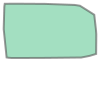

In [9]:
selected_leeds_polygon = selected_area_polygon(most_rta_latitude, most_rta_longitude)
selected_leeds_polygon

<b>Boundary of the selected Leeds road transport accident polygon</b>

In [10]:
bounds = selected_leeds_polygon.bounds
bounds

(-1.547783, 53.7931442, -1.5186735, 53.8102162)

<b>Area of the selected Leeds road transport accident polygon</b>

In [11]:
# Creating a GeoDataFrame from a Leeds RTA dataframe and specifying the geometry column
selected_leeds_rta_area = geopandas.GeoDataFrame(geometry=[selected_leeds_polygon])
# Setting the CRS of the GeoDataFrame to WGS84 (EPSG:4326)
selected_leeds_rta_area.crs = 'EPSG:4326'
selected_leeds_rta_area

,geometry
0,"POLYGON ((-1.54524 53.79314, -1.54615 53.79321..."


<b>Selecting only the accidents that falls inside the created polygon for analysis</b>

In [12]:
# Reference [4]
all_leeds_rta_geometry = leeds_rta_geodata_df.geometry
# Filter the Leeds road transport accident points to just those within selected area, 
# as defined by the polygon created earlier
selected_leeds_rta_points = leeds_rta_geodata_df[all_leeds_rta_geometry.within(selected_leeds_polygon)]
print(f'The number of accidents in the selected area from 2016 - 2019 are: {len(selected_leeds_rta_points)}')

selected_leeds_rta_points

The number of accidents in the selected area from 2016 - 2019 are: 706


,Reference Number,Grid Ref: Easting,Longitude,Grid Ref: Northing,Latitude,geometry,Number of Vehicles,Expr1,Accident Date,Time (24hr),1st Road Class,Road Surface,Lighting Conditions,Weather Conditions,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty,Type of Vehicle,1st Road Class & No,Accident Fields_Reference Number,Local Authority,Vehicle Fields_Reference Number,Vehicle Number,Casualty Fields_Reference Number,Casualty Veh No
32,3161098,429959,-1.546677,433326,53.795386,POINT (-1.54668 53.79539),2,Leeds 2016,06/01/2016,1723,Unclassified,Dry,Darkness: street lights present and lit,Fine without high winds,Driver or rider,Slight,Male,39,Pedal cycle,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,3191206,430876,-1.532664,434256,53.803691,POINT (-1.53266 53.80369),2,Leeds 2016,09/01/2016,1810,A,Wet / Damp,Darkness: street lights present and lit,Raining without high winds,Driver or rider,Slight,Male,23,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,3191206,430876,-1.532664,434256,53.803691,POINT (-1.53266 53.80369),2,Leeds 2016,09/01/2016,1810,A,Wet / Damp,Darkness: street lights present and lit,Raining without high winds,Driver or rider,Slight,Female,29,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,31D0289,430237,-1.542463,433264,53.794813,POINT (-1.54246 53.79481),1,Leeds 2016,07/01/2016,2155,Unclassified,Dry,Darkness: street lights present and lit,Fine without high winds,Pedestrian,Slight,Male,47,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,31E0436,430113,-1.544260,434139,53.802684,POINT (-1.54426 53.80268),1,Leeds 2016,13/01/2016,1705,Unclassified,Dry,Darkness: street lights present and lit,Fine without high winds,Pedestrian,Slight,Female,30,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8561,6C61387,430013,-1.545781,434115,53.802474,POINT (-1.54578 53.80247),2,NaN,06/12/2019,1740,6,2,4,1,1,3,1,27,1,U,NaN,E08000035,NaN,1.0,NaN,NaN
8562,6C70073,430028,-1.545556,434086,53.802213,POINT (-1.54556 53.80221),1,NaN,07/12/2019,10,6,2,4,2,3,2,2,34,8,U,NaN,E08000035,NaN,1.0,NaN,NaN
8576,6CB1299,430690,-1.535545,433675,53.798480,POINT (-1.53555 53.79848),2,NaN,11/12/2019,1700,3,1,4,1,1,3,1,41,1,A61,NaN,E08000035,NaN,2.0,NaN,NaN
8621,6CK2067,430765,-1.534390,433846,53.800013,POINT (-1.53439 53.80001),2,NaN,20/12/2019,2240,6,1,4,1,1,3,1,31,1,U,NaN,E08000035,NaN,2.0,NaN,NaN


<b>Road transport accident spots in Leeds for selected area</b>

In [13]:
rta_points_map(selected_leeds_rta_points, selected_leeds_polygon)

<b>Leeds road transport accidents network for selected area</b>

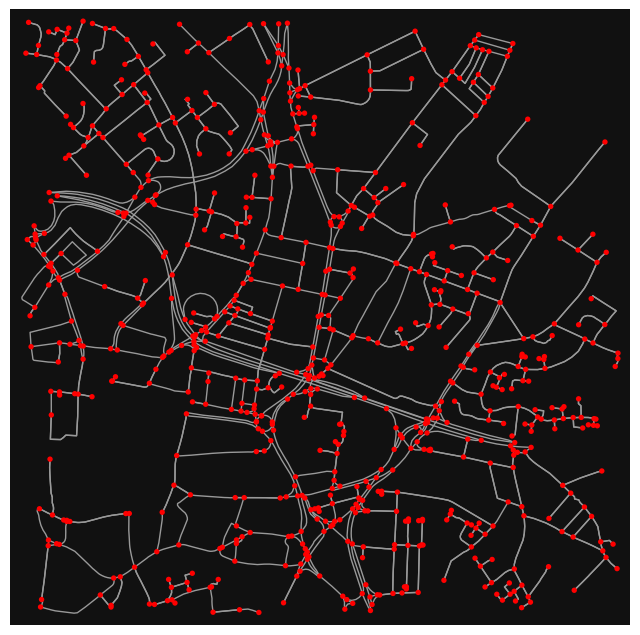

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [14]:
selected_leeds_rta_network = ox.graph_from_polygon(selected_leeds_polygon, network_type='drive')
ox.plot_graph(selected_leeds_rta_network, node_color='red')

<b>Area of selected Leeds road transport accidents polygon</b>

In [15]:
leeds_rta_selected_area_m2 = ox.project_gdf(selected_leeds_rta_area).unary_union.area
print(f'Area of the selected polygon in Leeds is: {leeds_rta_selected_area_m2} m² ({leeds_rta_selected_area_m2/1000000} km²)')

Area of the selected polygon in Leeds is: 3448672.918150295 m² (3.448672918150295 km²)


<b>Characteristics of the selected Leeds RTA network</b>

In [16]:
# Reference [4]
# Dataframe to display characteristics of the steet network graph
pd.set_option('display.max_colwidth', None)
network_stats(selected_leeds_rta_network, leeds_rta_selected_area_m2)

,Values
Nodes,735
Edges,1427
Average Degree,3.882993
Total Edge Length (m),94912.381
Average Edge Length (m),66.51183
Average Streets per Node,2.67483
Streets per Node Counts,"{0: 0, 1: 155, 2: 23, 3: 471, 4: 78, 5: 8}"
Streets per Node Proportions,"{0: 0.0, 1: 0.2108843537414966, 2: 0.031292517006802724, 3: 0.6408163265306123, 4: 0.10612244897959183, 5: 0.010884353741496598}"
Intersection Count,580
Total Street Length (m),64369.607


<b>Checking Planarity</b><br>
In graph theory, a planar graph is one that can be embedded in the plane, which means it can be represented on the plane with edges intersecting only at their ends, indicating that <b>no</b> edges cross one another.

In [17]:
# Reference [3]
# Check whether the graph is a planar graph, and it will apply Kuratowski's Theorem
is_planar, kuratowski_subgraphs = nx.check_planarity(selected_leeds_rta_network, counterexample=True)
print("Is the selected Leeds road transport accident graph planar?: ", is_planar)

Is the selected Leeds road transport accident graph planar?:  False


In [18]:
# Shows that there if there is a part of the network that is non-planar
kuratowski_subgraphs

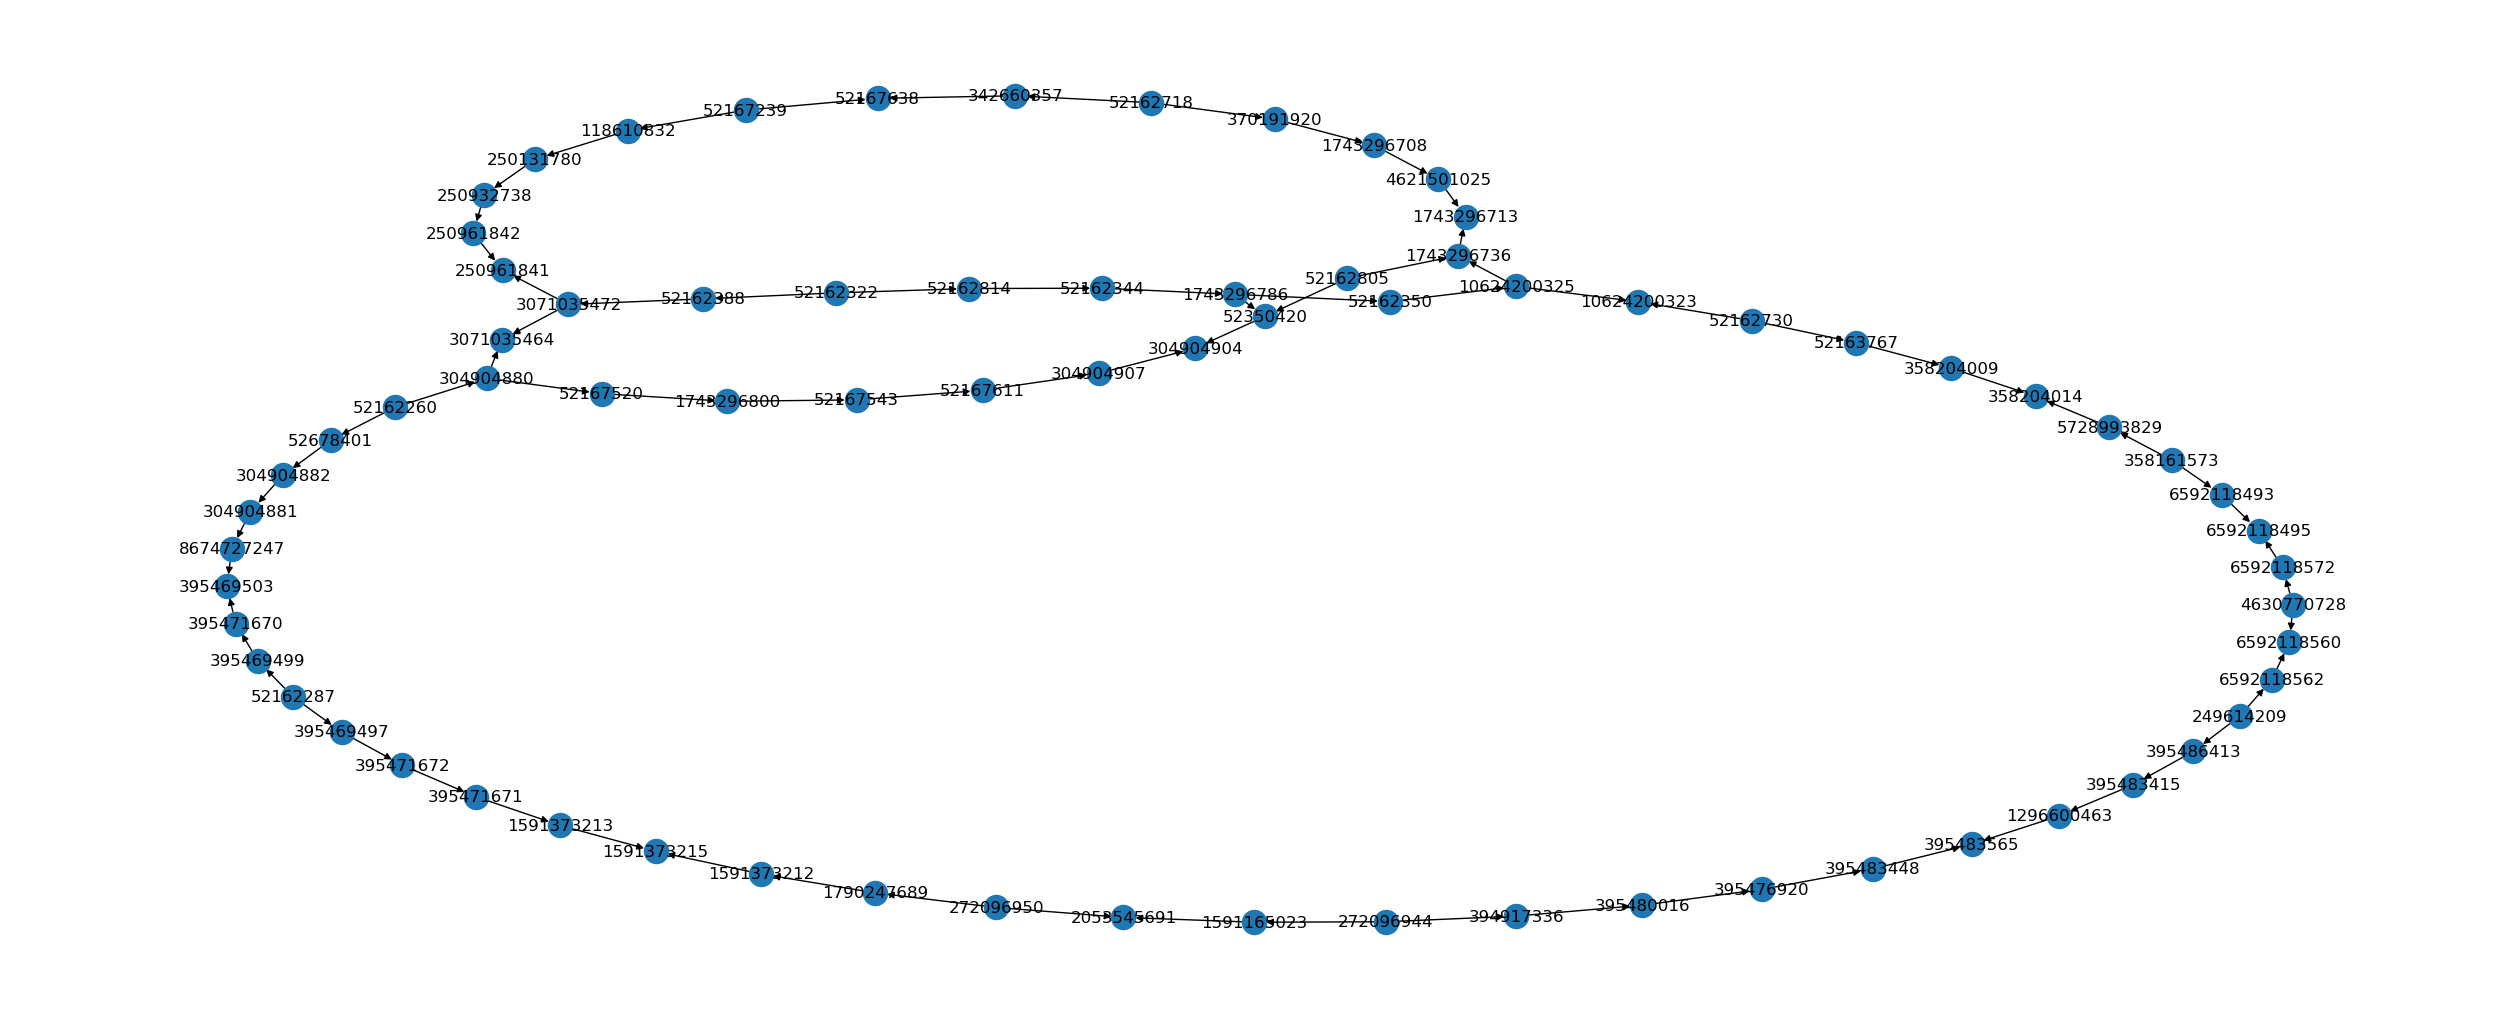

In [19]:
# Returning a part of the network that prevents Leeds road transport accident from being planar and draw it
plt.figure(figsize=(25, 10))
nx.draw(kuratowski_subgraphs, pos=nx.kamada_kawai_layout(kuratowski_subgraphs), arrows=True, 
        arrowstyle='-|>', with_labels=True)
plt.show()

<b>Displaying the roads on actual map on which accidents occurred in Leeds in selected area to confirm non-planarity due to presence of highways and subways</b>

In [20]:
ox.graph_to_gdfs(selected_leeds_rta_network, nodes=False).explore()

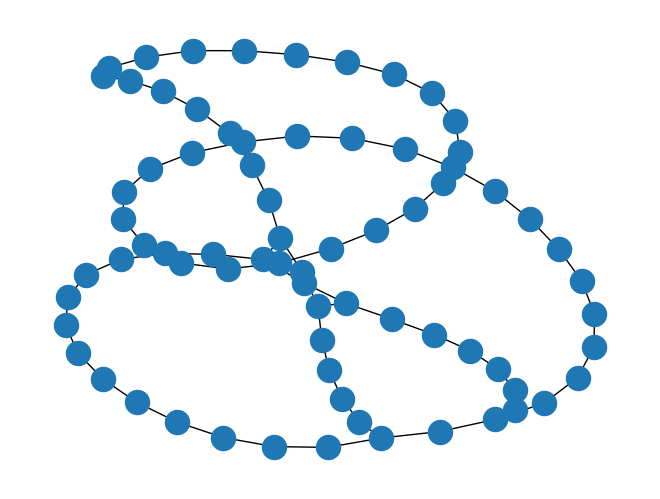

In [21]:
nx.draw(kuratowski_subgraphs)
counterexample = kuratowski_subgraphs

<b>Reference:</b> <br>
[1] https://stackoverflow.com/questions/45529507/unicodedecodeerror-utf-8-codec-cant-decode-byte-0x96-in-position-35-invalid <br>
[2] https://epsg.io/27700 <br>
[3] 7CUSMNDA - Network Data Analysis - Week 6 Lab and Solution <br>
[4] 7CUSMNDA - Network Data Analysis - Week 8 Lab and Solution <br>

<b>Extra - Experimental Code</b>

In [22]:
# Extracting edges from the Kuratowski subgraph
non_planar_edges = list(kuratowski_subgraphs.edges())

# Checking if the graph has at least one node and use its coordinates for the map location
if selected_leeds_rta_network.nodes:
    # Use the first node's coordinates for the map location
    map_location = [selected_leeds_rta_network.nodes[next(iter(selected_leeds_rta_network.nodes))]['y'],
                    selected_leeds_rta_network.nodes[next(iter(selected_leeds_rta_network.nodes))]['x']]

m = folium.Map(location=map_location, zoom_start=15)

# Plotting each edge of the non-planar subgraph
for edge in non_planar_edges:
    folium.PolyLine([(selected_leeds_rta_network.nodes[edge[0]]['y'], selected_leeds_rta_network.nodes[edge[0]]['x']),
                     (selected_leeds_rta_network.nodes[edge[1]]['y'], selected_leeds_rta_network.nodes[edge[1]]['x'])],
                    color='red').add_to(m)
# Display the map
m